# Colocalizations images

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import histlib.box as box
import histlib.aviso as aviso
import histlib.cstes as cstes
import histlib.diagnosis as diag
import histlib.erastar as eras
import histlib.stress_to_windterm as stw

from histlib.cstes import labels, zarr_dir, c0

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Load data

In [3]:
from histlib.matchup import matchup_dataset_one
l = 'gps_Sentinel-3_A_2020'#CHOOSE in labels
dsm = matchup_dataset_one(l, T=12, cutoff=[1.5, 2.5])
ds_eras = xr.open_zarr(zarr_dir+'_ok/erastar/erastar_'+l+'.zarr')[['es_alti_matchup_taue', 'es_alti_matchup_taun','es_drifter_matchup_taue', 'es_drifter_matchup_taun',]]
ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr').isel(alti_time =slice(80,-80))
ds_aviso =  xr.open_zarr(zarr_dir+'_ok/aviso/aviso_'+l+'.zarr')

236
236


In [12]:
def put_fig_letter(fig, ax, letter):
    import matplotlib.transforms as mtransforms
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, letter+')', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

_______________
## Visualize the whole colocalization in the geographical frame

In [5]:
def plot_coloc_matchup(label, nobs, dsm=dsm, ds_eras=ds_eras, ds_aviso=ds_aviso, ds_data=ds_data, figsize =(10,6), scaleera=1):
    #dataset
    _dsm = dsm.sel(obs=nobs).compute()
    dsoe = ds_eras.sel(obs=nobs).compute()
    dsdo = ds_data.sel(obs=nobs).compute()
    dsoa = ds_aviso.sel(obs=nobs).drop(['drifter_x', 'drifter_y','drifter_time']).compute()
    
    ## add ekman currents
    dsoe['es_drifter_matchup_ue'], dsoe['es_drifter_matchup_un'] = cst_rio_z15_currents(dsoe.es_drifter_matchup_taue, dsoe.es_drifter_matchup_taun, dsdo.f, dsdo.drifter_theta_lon.isel(site_obs=dsdo.__site_matchup_indice), dsdo.drifter_theta_lat.isel(site_obs=dsdo.__site_matchup_indice), rot=False)
    dsoe['es_drifter_matchup_ux'], dsoe['es_drifter_matchup_uy'] = cst_rio_z15_currents(dsoe.es_drifter_matchup_taue, dsoe.es_drifter_matchup_taun, dsdo.f, dsdo.drifter_theta_lon.isel(site_obs=dsdo.__site_matchup_indice), dsdo.drifter_theta_lat.isel(site_obs=dsdo.__site_matchup_indice), rot=True)
    dsoe['es_alti_matchup_ue'], dsoe['es_alti_matchup_un'] = cst_rio_z15_currents(dsoe.es_alti_matchup_taue, dsoe.es_alti_matchup_taun, dsdo.f, dsdo.box_theta_lon.sel(box_x=0, box_y=0), dsdo.box_theta_lat.sel(box_x=0, box_y=0), rot=False)
    dsoe['es_alti_matchup_ux'], dsoe['es_alti_matchup_uy'] = cst_rio_z15_currents(dsoe.es_alti_matchup_taue, dsoe.es_alti_matchup_taun, dsdo.f, dsdo.box_theta_lon.sel(box_x=0, box_y=0), dsdo.box_theta_lat.sel(box_x=0, box_y=0), rot=True)

    ## add ekman force in e,n
    dsoe['es_drifter_matchup_wd_e'], dsoe['es_drifter_matchup_wd_n'] = -dsdo.f*dsoe.es_drifter_matchup_un, dsdo.f*dsoe.es_drifter_matchup_ue
    dsoe['es_drifter_matchup_wd_x'], dsoe['es_drifter_matchup_wd_y'] = -dsdo.f*dsoe.es_drifter_matchup_uy, dsdo.f*dsoe.es_drifter_matchup_ux
    dsoe['es_alti_matchup_wd_e'], dsoe['es_alti_matchup_wd_n'] = -dsdo.f*dsoe.es_alti_matchup_un, dsdo.f*dsoe.es_alti_matchup_ue
    dsoe['es_alti_matchup_wd_x'], dsoe['es_alti_matchup_wd_y'] = -dsdo.f*dsoe.es_alti_matchup_uy, dsdo.f*dsoe.es_alti_matchup_ux
    
    ## add taux, tauy
    _ds = xr.merge([dsoe.drop(['drifter_lon', 'drifter_lat', 'drifter_time', 'drifter_x', 'drifter_y','box_x', 'box_y']), dsdo, dsoa])

    lon, lat, t_matchup = float(_dsm.lon), float(_dsm.lat), _dsm.time.values
    td = pd.to_datetime(t_matchup)
    dt = float(_ds["alti___time_difference"])
    dl = float(_ds["alti___distance"])
    
    #figure
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = fig.add_subplot(111, projection=ccrs.Orthographic(lon, lat))
    land_feature = cfeature.LAND

    # aviso
    min_=_ds["aviso_box_adt"].min()
    max_=_ds["aviso_box_adt"].max()
    if min_>0 : cmap='Reds'
    elif max_<0 : cmap='Blues'
    else : cmap='bwr'
    
    C=ax.contourf(_ds.box_lon, _ds.box_lat, _ds.aviso_box_adt, levels=30, cmap=cmap,transform=crs)
    

    #axes
    lonc, latc=_ds.box_lonc,_ds.box_latc
    ax_y=_ds.sel(box_x=0, box_y=100000)[['box_lon', 'box_lat']].compute()
    ax_x=_ds.sel(box_x=200000, box_y=0)[['box_lon', 'box_lat']].compute()
    x_lon, x_lat= ax_x.box_lon,ax_x.box_lat
    y_lon, y_lat= ax_y.box_lon,ax_y.box_lat
    
    ax.arrow(lonc,latc, y_lon-lonc, y_lat-latc, color='black', lw=3,transform=crs, head_width=0.1)
    ax.arrow(lonc,latc, x_lon-lonc, x_lat-latc, color='black', lw=3,transform=crs, head_width=0.1)
    ax.text(y_lon+0.5, y_lat,'Y',transform=crs, fontsize=15)
    ax.text(x_lon+0.5, x_lat,'X',transform=crs, fontsize=15)

    # drifter
    ax.scatter(_ds["drifter_lon"], _ds["drifter_lat"], c=np.arange(1, len(_ds["drifter_lat"].values)+1),cmap='viridis_r', marker='.',s=3, transform=crs, label="drifter's trajectory")
    ax.plot(_ds["drifter_lon"][0], _ds["drifter_lat"][0], "o", ms=5, color="y", transform=crs, label='start')
    ax.plot(_ds["drifter_lon"][-1], _ds["drifter_lat"][-1], "o", ms=10, color="navy", transform=crs, label='end')

    ax.plot(_dsm["drifter_lon"], _dsm["drifter_lat"], 
            "*", ms=20, color="g", lw=2, transform=crs, label="drifter's matchup point")
    #eras
    ax.quiver(np.array([_dsm["drifter_lon"],_ds["alti_lon"][25]]), np.array([_dsm["drifter_lat"],_ds["alti_lat"][25]]), np.array([_ds['es_drifter_matchup_taue'],_ds['es_alti_matchup_taue']]), np.array([_ds['es_drifter_matchup_taun'],_ds['es_alti_matchup_taun']]),
            color='mediumvioletred',transform=crs, lw=3, label='Wind stress from ERA star',scale=scaleera, width=0.01, zorder=4)
    #ax.quiver(np.array([_dsm["drifter_lon"],_ds["alti_lon"][45]]), np.array([_dsm["drifter_lat"],_ds["alti_lat"][45]]), np.array([_ds['es_drifter_matchup_ue'],_ds['es_alti_matchup_ue']]), np.array([_ds['es_drifter_matchup_un'],_ds['es_alti_matchup_un']]),
    #         color='white',transform=crs, lw=3, label='Ekman current from ERA star', zorder=4)#scale=1e10, width=0.01,
    #ax.quiver(np.array([_dsm["drifter_lon"],_ds["alti_lon"][45]]), np.array([_dsm["drifter_lat"],_ds["alti_lat"][45]]), np.array([_ds['es_drifter_matchup_wd_e'],_ds['es_alti_matchup_wd_e']]), np.array([_ds['es_drifter_matchup_wd_n'],_ds['es_alti_matchup_wd_n']]),
    #         color='y',transform=crs, lw=3, label='Ekman acceleration from ERA star', zorder=4)#scale=1e10, width=0.01,
    
    # altimetry
    ax.scatter(_ds["alti_lon"], _ds["alti_lat"], s=np.arange(1, len(_ds["alti_lon"].values)+1)*0.2, color="orange", transform=crs, label= "satelitte's track")
    ax.plot(_ds["alti_lon"][0], _ds["alti_lat"][0], ".", ms=5, color="orange", transform=crs, label='start')
    ax.plot(_ds["alti_lon"][-1], _ds["alti_lat"][-1], ".", ms=20, color="orange", transform=crs,label='end')
    ax.plot(_ds["alti_lon"][25], _ds["alti_lat"][25], "*", ms=20, color="darkorange", lw=2, transform=crs, label="altimeter's matchup point")
    
    gl = ax.gridlines(draw_labels=True, dms=False, 
                 x_inline=False, y_inline=False, 
                )
    gl.right_labels=False
    gl.top_labels=False

    ax.set_title(label + f" colocalization n°{nobs} \n dl={dl/1e3:.1f}km , dt={dt/60:.1f}min , matchup time = "+td.strftime("%Y/%m/%d %H:%M"))#+f'\n lon={round(lon} lat={lat}')
    fig.legend(loc="lower center",  ncol=2, fontsize=10)
    fig.colorbar(C, label ='ADT from AVISO [m]')
    fig.tight_layout(rect=[0,0.2,1,1])
    return fig
    
    #images_dir = "/home1/datahome/mdemol/m2_2022/images/"

    #fig.savefig(images_dir+f'label0_nobs{nobs}.png', dpi=200)

In [133]:
def plot_coloc_matchup_v2(label, nobs, dsm=dsm, ds_eras=ds_eras, ds_aviso=ds_aviso, ds_data=ds_data, figsize =(10,6), scale=5e-6):
    #dataset
    _dsm = dsm.sel(obs=nobs).compute()
    dsoe = ds_eras.sel(obs=nobs).compute()
    dsdo = ds_data.sel(obs=nobs).compute()
    dsoa = ds_aviso.sel(obs=nobs).drop(['drifter_x', 'drifter_y','drifter_time']).compute()
    
    ## add ekman force
    dsoe['es_drifter_matchup_wd_e'], dsoe['es_drifter_matchup_wd_n'] = stw.cst_rio_z15(dsoe.es_drifter_matchup_taue, dsoe.es_drifter_matchup_taun, dsdo.f, dsdo.drifter_theta_lon.isel(site_obs=dsdo.__site_matchup_indice), dsdo.drifter_theta_lat.isel(site_obs=dsdo.__site_matchup_indice), rot=False)
    ## add taux, tauy
    _ds = xr.merge([dsoe, dsdo, dsoa])

    lon, lat, t_matchup = float(_dsm.lon), float(_dsm.lat), _dsm.time.values
    td = pd.to_datetime(t_matchup)
    dt = float(_ds["alti___time_difference"])
    dl = float(_ds["alti___distance"])
    
    #figure
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = fig.add_subplot(111, projection=ccrs.Orthographic(lon, lat))
    land_feature = cfeature.LAND

    # aviso
    min_=_ds["aviso_box_adt"].min()
    max_=_ds["aviso_box_adt"].max()
    if min_>0 : cmap='Reds'
    elif max_<0 : cmap='Blues'
    else : cmap='bwr'
    
    C=ax.contourf(_ds.box_lon, _ds.box_lat, _ds.aviso_box_adt, levels=30, cmap=cmap,  transform=crs)
    
    #axes
    lonc, latc=_ds.box_lonc,_ds.box_latc
    ax_y=_ds.sel(box_x=0, box_y=100000)[['box_lon', 'box_lat']].compute()
    ax_x=_ds.sel(box_x=200000, box_y=0)[['box_lon', 'box_lat']].compute()
    x_lon, x_lat= ax_x.box_lon,ax_x.box_lat
    y_lon, y_lat= ax_y.box_lon,ax_y.box_lat
    
    ax.arrow(lonc,latc, y_lon-lonc, y_lat-latc, color='black', lw=3,transform=crs, head_width=0.1)
    ax.arrow(lonc,latc, x_lon-lonc, x_lat-latc, color='black', lw=3,transform=crs, head_width=0.1)
    ax.text(y_lon+0.5, y_lat,'Y',transform=crs, fontsize=15)
    ax.text(x_lon+0.5, x_lat,'X',transform=crs, fontsize=15)

    X = np.array(x_lon-lonc, x_lat-latc)/np.sqrt((x_lon-lonc)**2+(x_lat-latc)**2)
    Y = np.array(y_lon-lonc, y_lat-latc)/np.sqrt((y_lon-lonc)**2+(y_lat-latc)**2)

    def projX(vect, X):
        return np.dot(vect, X.transpose())
        
    def rot(x, y, phi) :
        return (x*np.cos(phi) + y*np.sin(phi)).values, (x*np.sin(phi) - y*np.cos(phi)).values

    # drifter
    ax.scatter(_ds["drifter_lon"], _ds["drifter_lat"], c=np.arange(1, len(_ds["drifter_lat"].values)+1),cmap='viridis_r', marker='.',s=3, transform=crs, label="drifter's trajectory")
    ax.plot(_ds["drifter_lon"][0], _ds["drifter_lat"][0], "o", ms=5, color="y", transform=crs, label='start')
    ax.plot(_ds["drifter_lon"][-1], _ds["drifter_lat"][-1], "o", ms=10, color="navy", transform=crs, label='end')

    ax.plot(_dsm["drifter_lon"], _dsm["drifter_lat"],  "*", ms=20, color="g", lw=2, transform=crs, label="drifter's matchup point")

    ACC = rot(_dsm.drifter_acc_x_25, 0, -_ds.box_phi)
    CORIOLIS = rot(_dsm.drifter_coriolis_x_25, 0, -_ds.box_phi)

    ax.quiver(x=np.array([_dsm["drifter_lon"], _dsm["drifter_lon"]]), y=np.array([_dsm["drifter_lat"],_dsm["drifter_lat"]]), u=np.array([ACC[0], CORIOLIS[0]]), v=np.array([ACC[1],CORIOLIS[1]]), color=[c0['acc'], c0['coriolis']],transform=crs, lw=3, label=['Inertial acceleration', 'Coriolis acceleration'], scale=scale, width=0.01, zorder=4)
    
    #eras
    WIND = rot(_dsm.es_cstrio_z15_drifter_wd_x, 0, -_ds.box_phi)
    print(WIND)
    ax.quiver(np.array([_dsm["drifter_lon"]]), np.array([_dsm["drifter_lat"]]), np.array([WIND[0]]), np.array([WIND[1]]),
              color=c0['wind'],transform=crs, lw=3, label='Wind term',scale=scale, width=0.01, zorder=4)
    
    # altimetry
    ax.scatter(_ds["alti_lon"], _ds["alti_lat"], s=np.arange(1, len(_ds["alti_lon"].values)+1)*0.2, color="orange", transform=crs, label= "satelitte's track")
    ax.plot(_ds["alti_lon"][0], _ds["alti_lat"][0], ".", ms=5, color="orange", transform=crs, label='start')
    ax.plot(_ds["alti_lon"][-1], _ds["alti_lat"][-1], ".", ms=20, color="orange", transform=crs,label='end')
    ax.plot(_ds["alti_lon"][25], _ds["alti_lat"][25], "*", ms=20, color="darkorange", lw=2, transform=crs, label="altimeter's matchup point")
    
    GGRAD = rot(_dsm.alti_ggx_adt_filtered+_dsm.alti_ggx_ocean_tide + _dsm.alti_ggx_internal_tide, 0, -_ds.box_phi)
    ax.quiver(np.array([_ds["alti_lon"][25]]), np.array([_ds["alti_lat"][25]]), np.array([GGRAD[0]]), np.array([GGRAD[1]]),
              color=c0['ggrad'],transform=crs, lw=3, label='Pressure gradient term',scale=scale, width=0.01, zorder=4)
    
    # plot
    gl = ax.gridlines(draw_labels=True, dms=False, 
                 x_inline=False, y_inline=False, )
    gl.right_labels=False
    gl.top_labels=False

    ax.set_title(label + f" colocalization n°{nobs} \n dl={dl/1e3:.1f}km , dt={dt/60:.1f}min , matchup time = "+td.strftime("%Y/%m/%d %H:%M"))#+f'\n lon={round(lon} lat={lat}')
    fig.legend(loc="lower center",  ncol=2, fontsize=10)
    fig.colorbar(C, label ='ADT from AVISO [m]')
    fig.tight_layout(rect=[0,0.2,1,1])
    return fig
    
    #images_dir = "/home1/datahome/mdemol/m2_2022/images/"

    #fig.savefig(images_dir+f'label0_nobs{nobs}.png', dpi=200)

In [6]:
fig = plot_coloc_matchup(l, 11806, scale=1e-5)
#fig.savefig('images/'+f'label0_nobs12166.png', dpi=300)

NameError: name 'plot_coloc_matchup' is not defined

_______________
## Visualize the whole colocalization in the local frame + small image of the geographical frame
Allow to show vectors

In [6]:
def plot_coloc_matchup_in_ins(ins, label, nobs, dsm=dsm, ds_eras=ds_eras, ds_aviso=ds_aviso, ds_data=ds_data):
    #dataset
    _dsm = dsm.sel(obs=nobs).compute()
    dsoe = ds_eras.sel(obs=nobs).compute()
    dsdo = ds_data.sel(obs=nobs).compute()
    dsoa = ds_aviso.sel(obs=nobs).drop(['drifter_x', 'drifter_y','drifter_time']).compute()

    _ds = xr.merge([dsdo, dsoa])

    lon, lat, t_matchup = float(_dsm.lon), float(_dsm.lat), _dsm.time.values
    td = pd.to_datetime(t_matchup)
    dt = float(_ds["alti___time_difference"])
    dl = float(_ds["alti___distance"])

    land_feature = cfeature.LAND

    # aviso
    #min_=_ds["aviso_box_adt"].min()
    max_=_ds["aviso_box_adt"].max()
    #if min_>0 : cmap='Reds'
    #elif max_<0 : cmap='Blues'
    #else : cmap='bwr'
    cmap='bwr'
    min_=abs(_ds["aviso_box_adt"].min())
    max_=abs(_ds["aviso_box_adt"].max())
    a=max(min_,max_)
    
    C=ins.contourf(_ds.box_lon, _ds.box_lat, _ds.aviso_box_adt, levels=30, cmap=cmap,transform=crs)
    
    #axes
    lonc, latc=_ds.box_lonc,_ds.box_latc
    ax_y=_ds.sel(box_x=0, box_y=100000)[['box_lon', 'box_lat']].compute()
    ax_x=_ds.sel(box_x=200000, box_y=0)[['box_lon', 'box_lat']].compute()
    x_lon, x_lat= ax_x.box_lon,ax_x.box_lat
    y_lon, y_lat= ax_y.box_lon,ax_y.box_lat
    
    ins.arrow(lonc,latc, y_lon-lonc, y_lat-latc, color='black', lw=3,transform=crs, head_width=0.1)
    ins.arrow(lonc,latc, x_lon-lonc, x_lat-latc, color='black', lw=3,transform=crs, head_width=0.1)
    ins.text(y_lon+0.5, y_lat,'Y',transform=crs, fontsize=15)
    ins.text(x_lon+0.5, x_lat,'X',transform=crs, fontsize=15)

    X = np.array(x_lon-lonc, x_lat-latc)/np.sqrt((x_lon-lonc)**2+(x_lat-latc)**2)
    Y = np.array(y_lon-lonc, y_lat-latc)/np.sqrt((y_lon-lonc)**2+(y_lat-latc)**2)


    # drifter
    ins.scatter(_ds["drifter_lon"], _ds["drifter_lat"], c=np.arange(1, len(_ds["drifter_lat"].values)+1),cmap='viridis_r', marker='.',s=3, transform=crs)
    ins.plot(_ds["drifter_lon"][0], _ds["drifter_lat"][0], "o", ms=3, color="y", transform=crs,)
    ins.plot(_ds["drifter_lon"][-1], _ds["drifter_lat"][-1], "o", ms=5, color="navy", transform=crs)

    ins.plot(_dsm["drifter_lon"], _dsm["drifter_lat"],  "*", ms=10, color="g", lw=2, transform=crs)
        
    # altimetry
    ins.scatter(_ds["alti_lon"], _ds["alti_lat"], s=np.arange(1, len(_ds["alti_lon"].values)+1)*0.2, color="k", transform=crs)
    ins.plot(_ds["alti_lon"][0], _ds["alti_lat"][0], ".", ms=3, color="k", transform=crs, )
    ins.plot(_ds["alti_lon"][-1], _ds["alti_lat"][-1], ".", ms=len(_ds["alti_lon"].values)*0.2, color="k", transform=crs)
    ins.plot(_ds["alti_lon"][25], _ds["alti_lat"][25], "*", ms=10, color=c0['ggrad'], lw=2, transform=crs, )
    
    # plot
    gl =ins.gridlines(draw_labels=True, dms=False, 
                 x_inline=False, y_inline=False, )
    gl.left_labels=False
    gl.top_labels=False


In [13]:
def plot_coloc_matchup_xy(label, nobs, dsm=dsm, ds_eras=ds_eras, ds_aviso=ds_aviso, ds_data=ds_data, figsize =(10,6), scale=5e-5):
    w=0.007

    #dataset
    _dsm = dsm.sel(obs=nobs).compute()
    dsdo = ds_data.sel(obs=nobs).compute()
    dsoa = ds_aviso.sel(obs=nobs).drop(['drifter_x', 'drifter_y', 'drifter_time']).compute()

    ## add taux, tauy
    _ds = xr.merge([dsdo, dsoa])

    lon, lat, t_matchup = float(_dsm.lon), float(_dsm.lat), _dsm.time.values
    td = pd.to_datetime(t_matchup)
    dt = float(_ds["alti___time_difference"])
    dl = float(_ds["alti___distance"])
    
    #figure
    fig, ax = plt.subplots(1,1,figsize=figsize)
    
    # aviso
    min_=abs(_ds["aviso_box_adt"].min())
    max_=abs(_ds["aviso_box_adt"].max())
    a=max(min_,max_)
    cmap='bwr'
    C=ax.contourf(_ds.box_x, _ds.box_y, _ds.aviso_box_adt, levels=30, cmap=cmap)
    AVISO = _dsm.drifter_acc_x_25, _dsm.drifter_acc_y_25

    #axes
    xc, yc=0,0
    ax_y=_ds.sel(box_x=0, box_y=50000)[['box_x', 'box_y']].compute()
    ax_x=_ds.sel(box_x=100000, box_y=0)[['box_x', 'box_y']].compute()
    x_x, x_y= ax_x.box_x,ax_x.box_y
    y_x, y_y= ax_y.box_x,ax_y.box_y
    #ax.arrow(xc, yc, y_x-xc, (y_y-yc), color='black', lw=3, head_width=10)
    #ax.arrow(xc, yc, x_x-xc, (x_y-yc), color='black', lw=3, head_width=10)
    ax.arrow(xc, yc, 0, 50000, color='black', lw=3, head_width=10)
    ax.arrow(xc, yc, 200000, 0, color='black', lw=3, head_width=10)
    ax.text(50, 50000,'Y', fontsize=15)
    ax.text(200000, 500,'X', fontsize=15)

    # drifter
    ax.scatter(_ds["drifter_x"], _ds["drifter_y"], c=np.arange(1, len(_ds["drifter_x"].values)+1),cmap='viridis_r', marker='.',s=3, label="drifter's trajectory")
    ax.plot(_ds["drifter_x"][0], _ds["drifter_y"][0], "o", ms=5, color="y",  label='start')
    ax.plot(_ds["drifter_x"][-1], _ds["drifter_y"][-1], "o", ms=10, color="navy",  label='end')

    ax.plot(_dsm["drifter_x"], _dsm["drifter_y"],"*", ms=20, color="g", lw=2, label="drifter-matchup point")

    ACC = _dsm.drifter_acc_x_25.values, _dsm.drifter_acc_y_25.values
    CORIOLIS = _dsm.drifter_coriolis_x_25.values, _dsm.drifter_coriolis_y_25.values
    ax.quiver(np.array([_dsm["drifter_x"]]), np.array([_dsm["drifter_y"]]), np.array([ACC[0]]), np.array([ACC[1]]), color=[c0['acc']], lw=3, label='Inertial acceleration', scale=scale, width=w, zorder=4)
    ax.quiver(np.array([ _dsm["drifter_x"]]), np.array([_dsm["drifter_y"]]), np.array([ CORIOLIS[0]]), np.array([CORIOLIS[1]]), color=[c0['coriolis']], lw=3, label='Coriolis acceleration', scale=scale, width=w, zorder=4)
    
    #eras
    ax.quiver(np.array([_dsm["drifter_x"]]), np.array([_dsm["drifter_y"]]), np.array([_dsm.es_cstrio_z15_drifter_wd_x]), np.array([_dsm.es_cstrio_z15_drifter_wd_y]),
             color=c0['wind'], lw=3, label='Wind term', zorder=7, scale=scale/2, width=w,)
    
    # altimetry
    ax.scatter(_ds["alti_x"], _ds["alti_y"], s=np.arange(1, len(_ds["alti_x"].values)+1)*0.5, color='k', label= "satelitte's track")
    ax.plot(_ds["alti_x"][0], _ds["alti_y"][0], ".", ms=5, color='k', label='start')
    ax.plot(_ds["alti_x"][-1], _ds["alti_y"][-1], ".", ms=len(_ds["alti_x"].values)*0.3, color='k', label='end')
    ax.plot(_ds["alti_x"][25], _ds["alti_y"][25], "*", ms=20, color=c0['ggrad'], lw=2, label="altimeter-matchup point")
    GGRAD_ALG = _dsm.alti_ggx_adt_filtered+_dsm.alti_ggx_ocean_tide + _dsm.alti_ggx_internal_tide, 0
    GGRAD_AVISO = _dsm.aviso_drifter_ggx_adt, _dsm.aviso_drifter_ggy_adt,
    ax.quiver(np.array([ _ds["alti_x"][25]]), np.array([_ds["alti_y"][25]]), np.array([ GGRAD_ALG[0]]), np.array([GGRAD_ALG[1]]), color=[c0['ggrad']], lw=3, label='Along-track pressure gradient term', scale=scale, width=w, zorder=4)
    ax.quiver(np.array([ _dsm["drifter_x"]]), np.array([_dsm["drifter_y"]]), np.array([ GGRAD_AVISO[0]]), np.array([GGRAD_AVISO[1]]), color=['navy'], lw=3, label='AVISO pressure gradient term', scale=scale, width=w, zorder=4)

    #ax.quiver(np.array([ _dsm["alti_x"]]), np.array([_dsm["alti_y"]]), np.array([ CORIOLIS[0]]), np.array([CORIOLIS[1]]), color=[c0['coriolis']], lw=3, label='Coriolis acceleration', scale=scale, width=w, zorder=4)

    # inserted plot
    def reposition():
        plt.draw()
        p1 = ax.get_position()
        p2 = ax2.get_position()
        ax2.set_position([0.29, 1-p2.height-0.06, p2.width, p2.height])
    ax2 = fig.add_axes([0.6, 0.6, 0.2, 0.2], projection=ccrs.PlateCarree())
    plot_coloc_matchup_in_ins(ax2, label, nobs, dsm=dsm, ds_eras=ds_eras, ds_aviso=ds_aviso, ds_data=ds_data)
    reposition()

    ax.set_title(label + rf"n°{nobs}"+"\n")#+rf"$\Delta X$={dl/1e3:.1f}km , $\Delta T$={dt/60:.1f}min")
    ax.set_ylim(-200000, 200000)
    ax.set_xlim(-300000, 300000)
    ax.set_xlabel('X[km]')
    ax.set_ylabel('Y[km]')
    ax.set_aspect('equal')

    put_fig_letter(fig, ax, 'a')
    fig.legend(loc="lower center",  ncol=2, fontsize=10)
    fig.colorbar(C, label ='ADT from AVISO [m]')
    fig.tight_layout(rect=[0,0.3,1,1])#left, bottom, right, top (default is 0,0,1,1)

    images_dir = "images_all/coloc/"

    fig.savefig(images_dir+f'label0_nobs{nobs}.png', dpi=300, bbox_inches="tight")

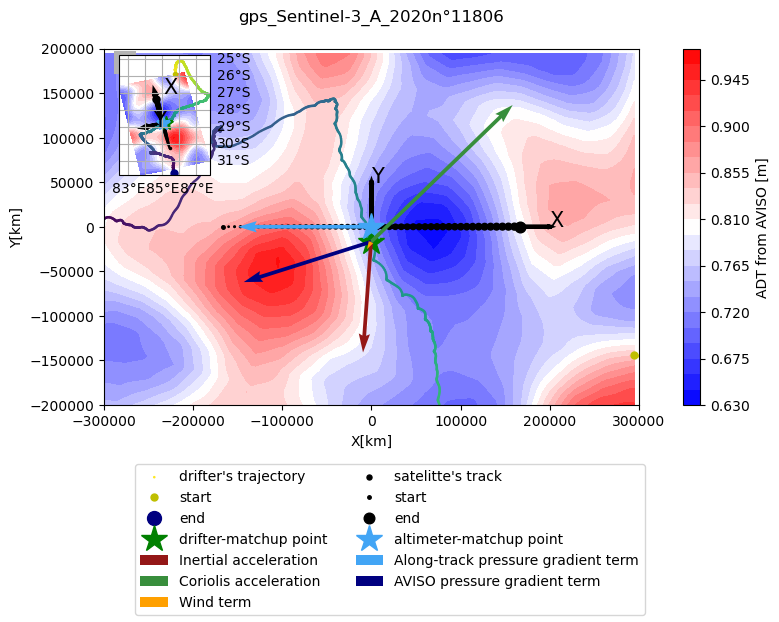

In [14]:
plot_coloc_matchup_xy(l, 11806, scale=1e-4)

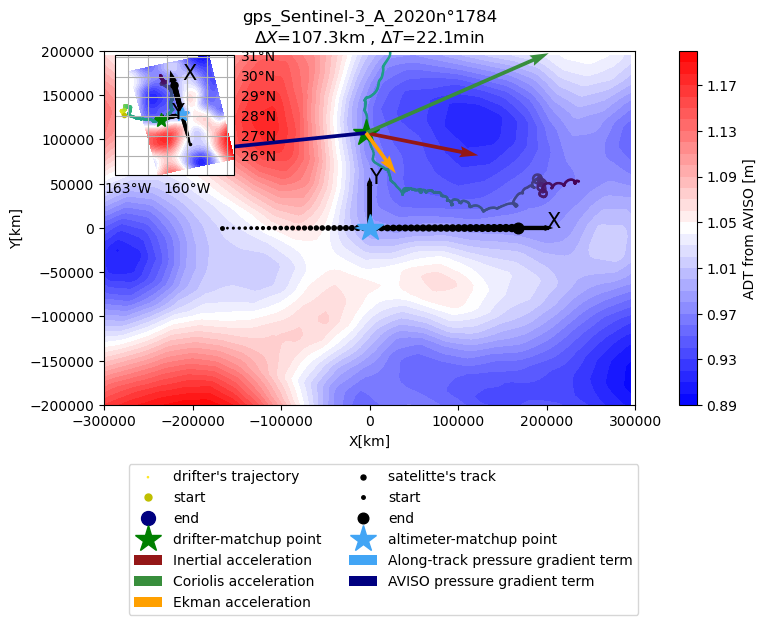

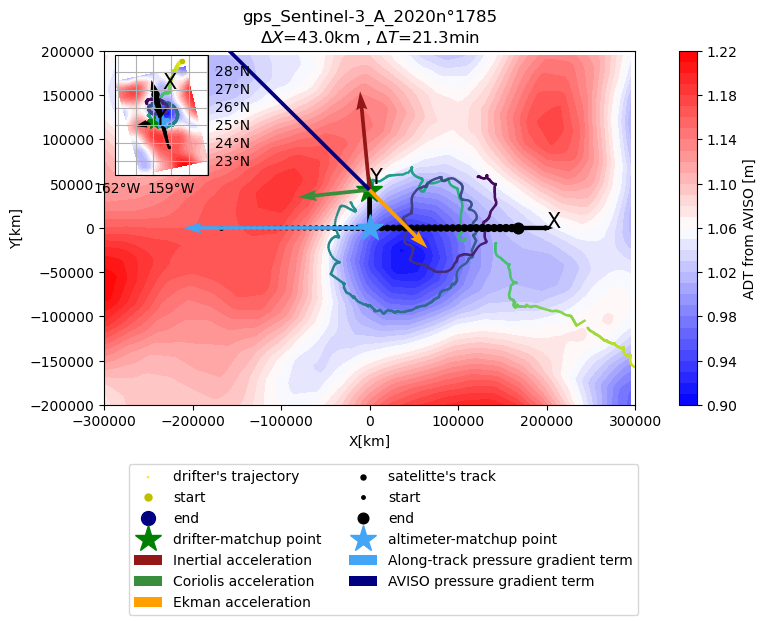

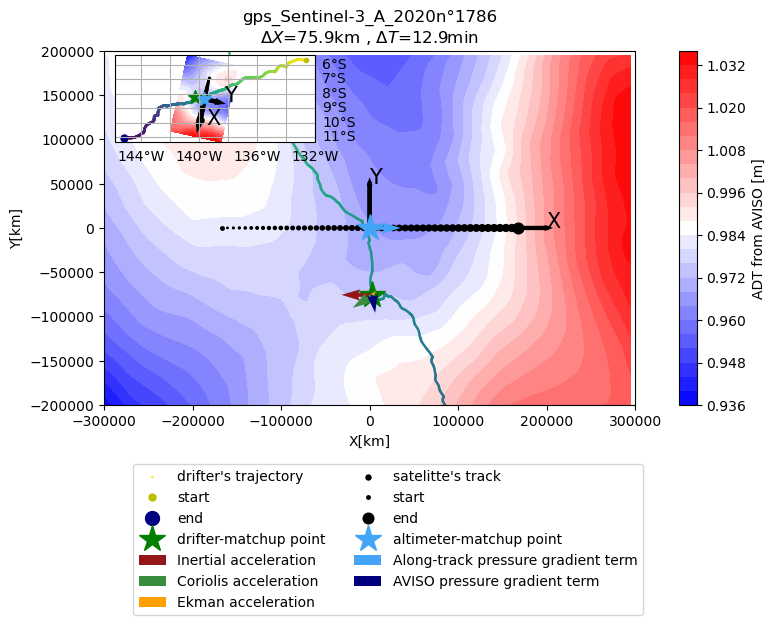

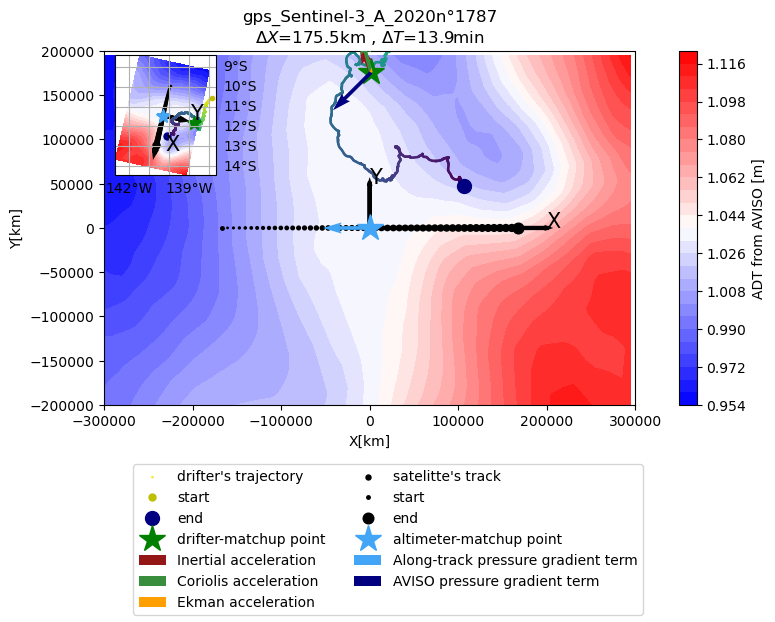

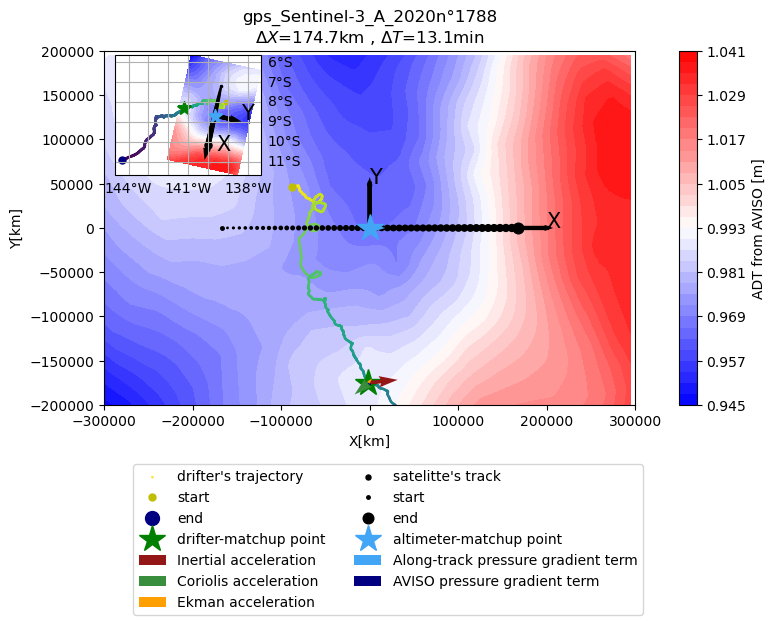

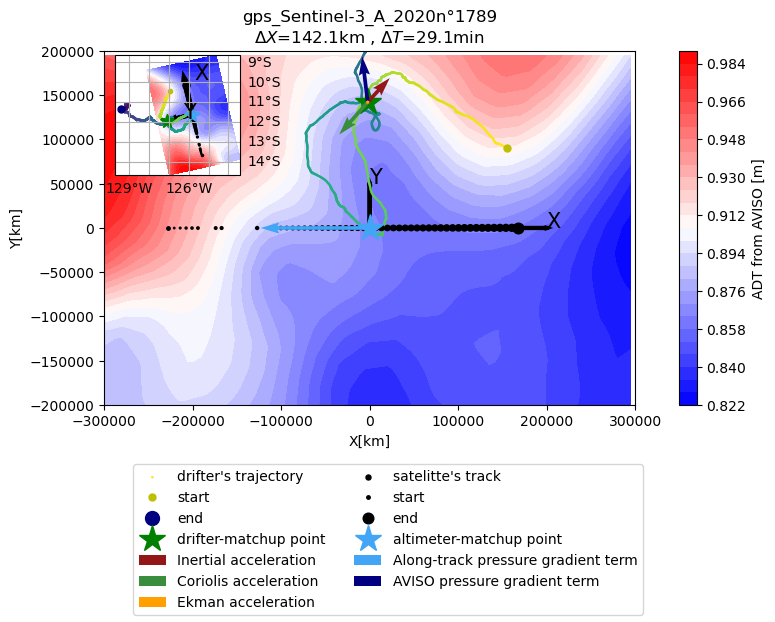

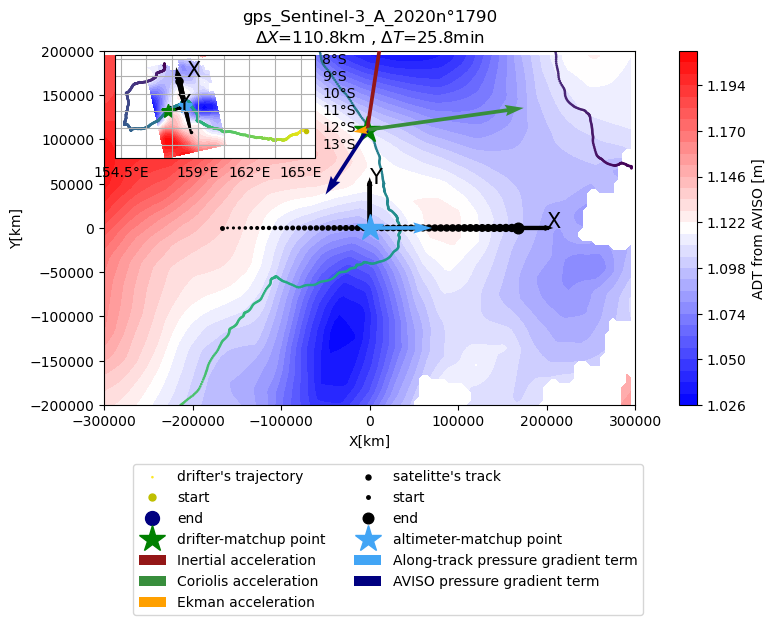

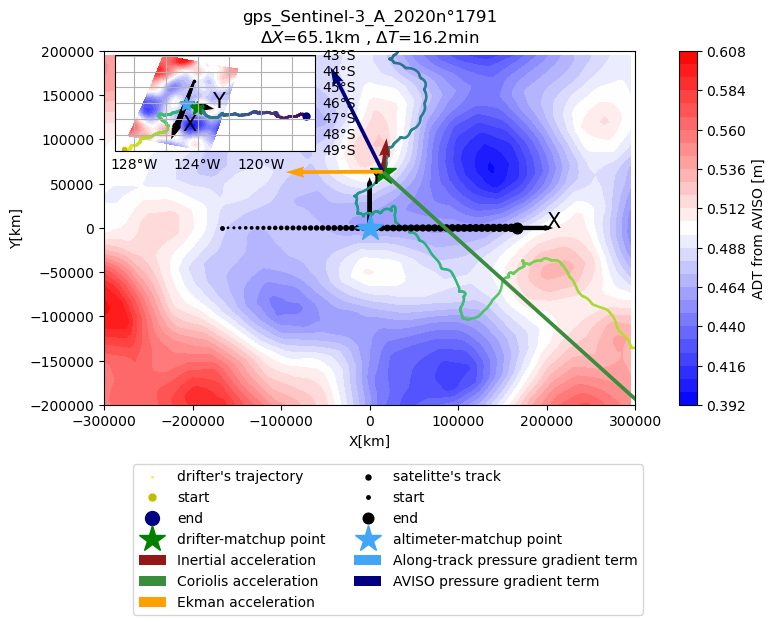

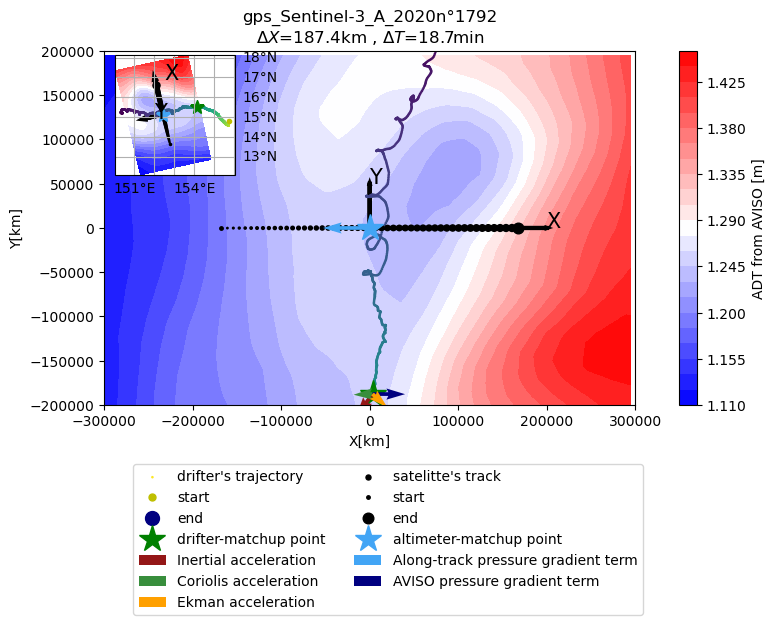

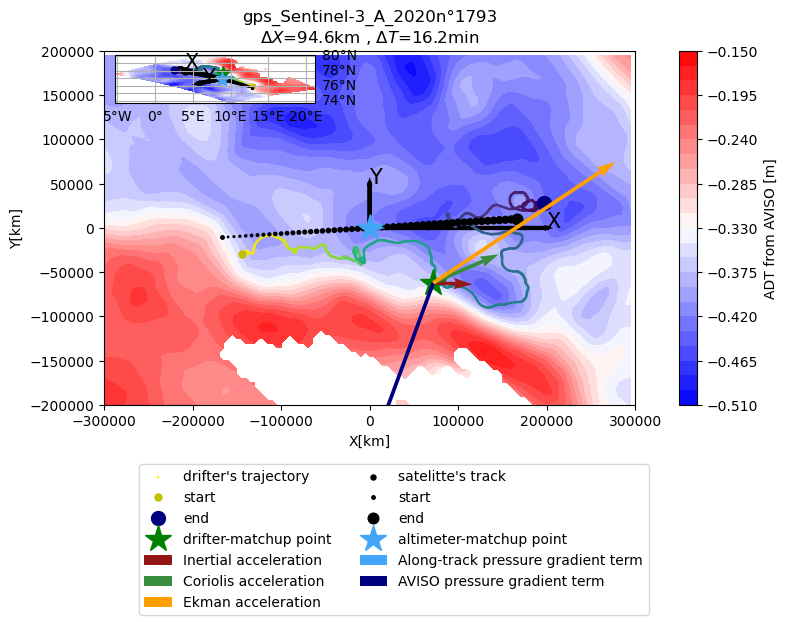

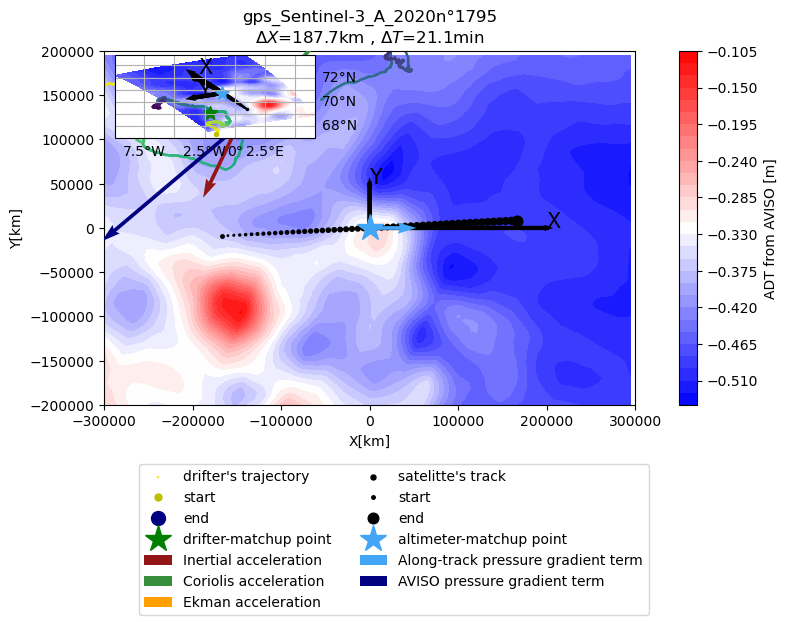

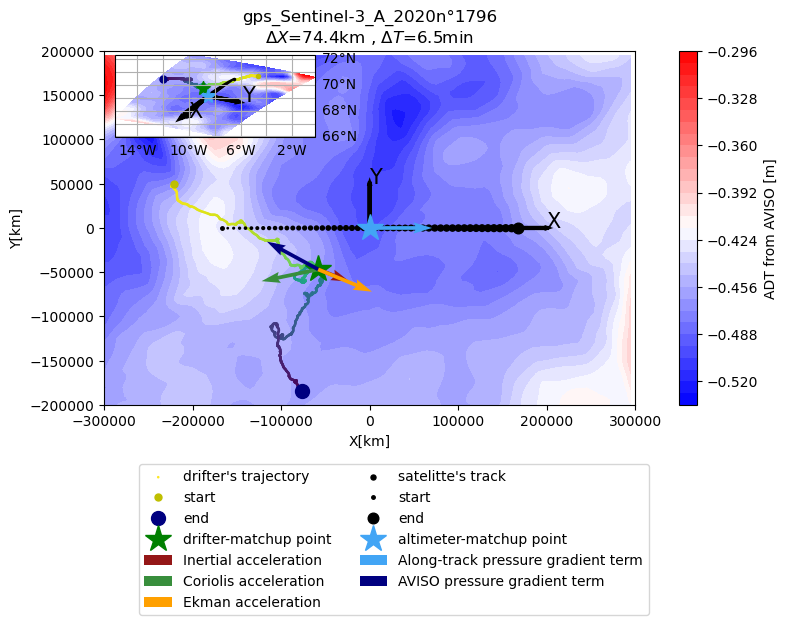

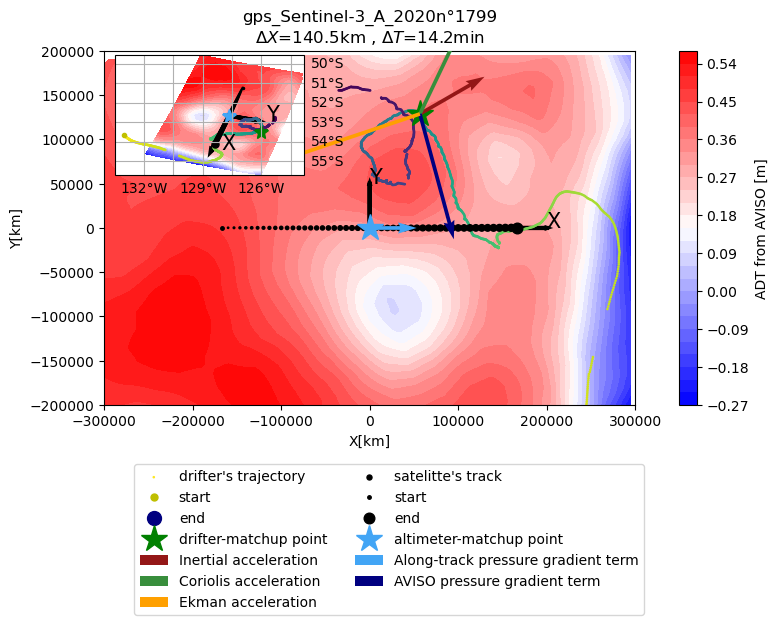

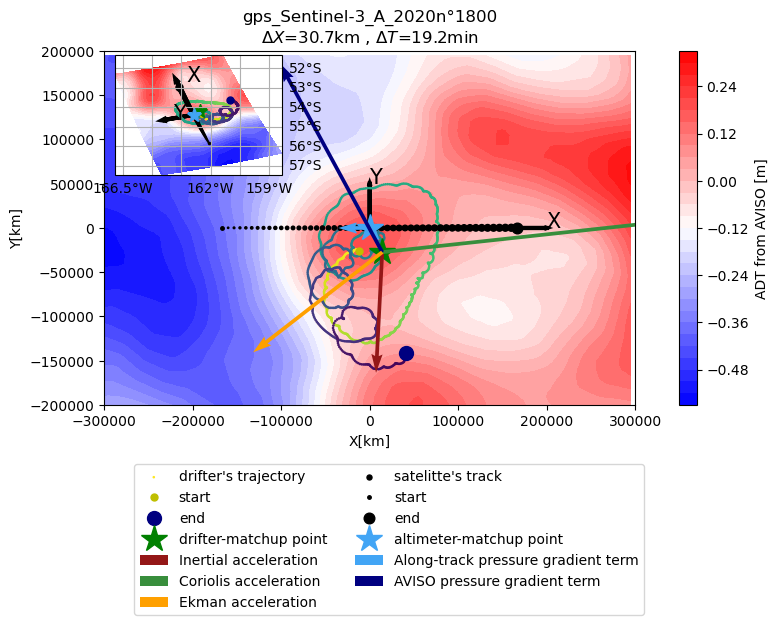

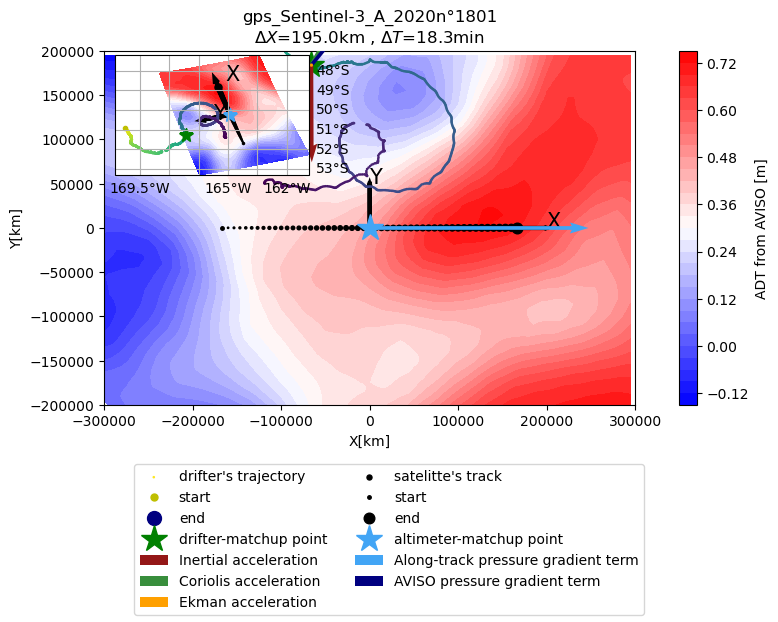

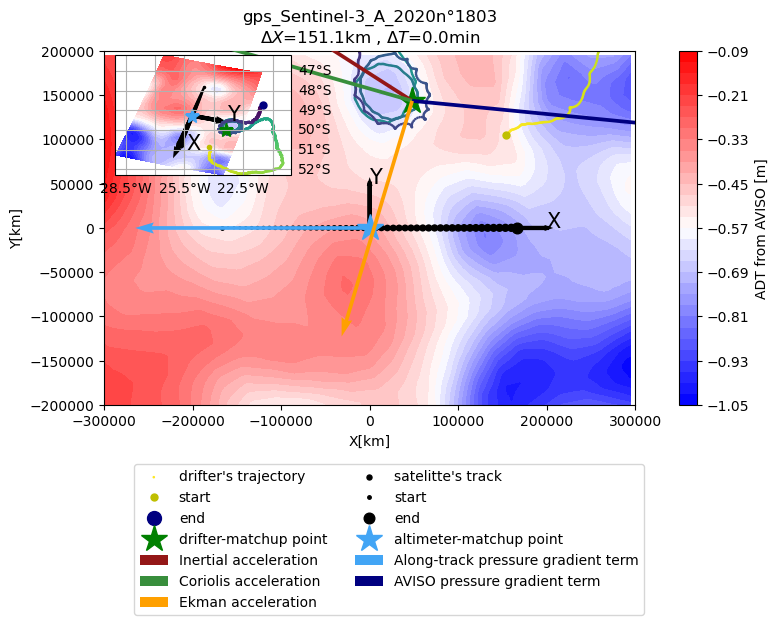

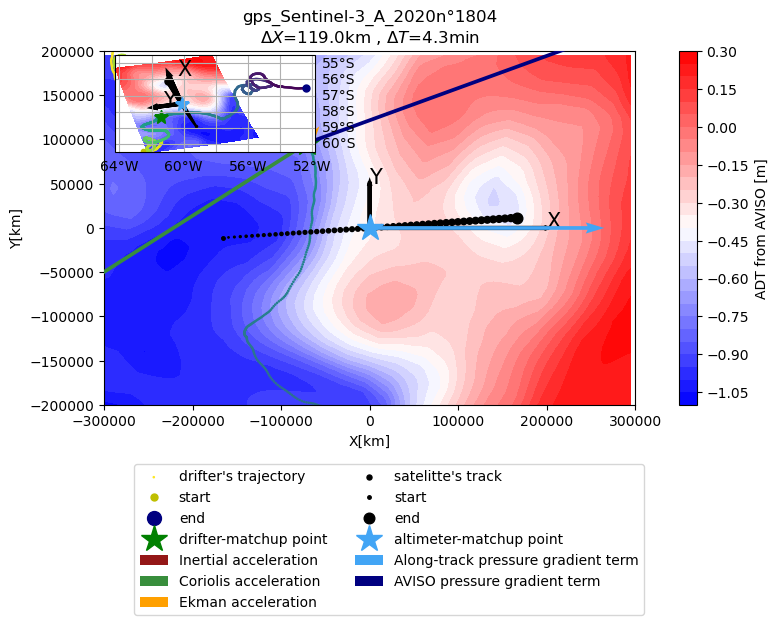

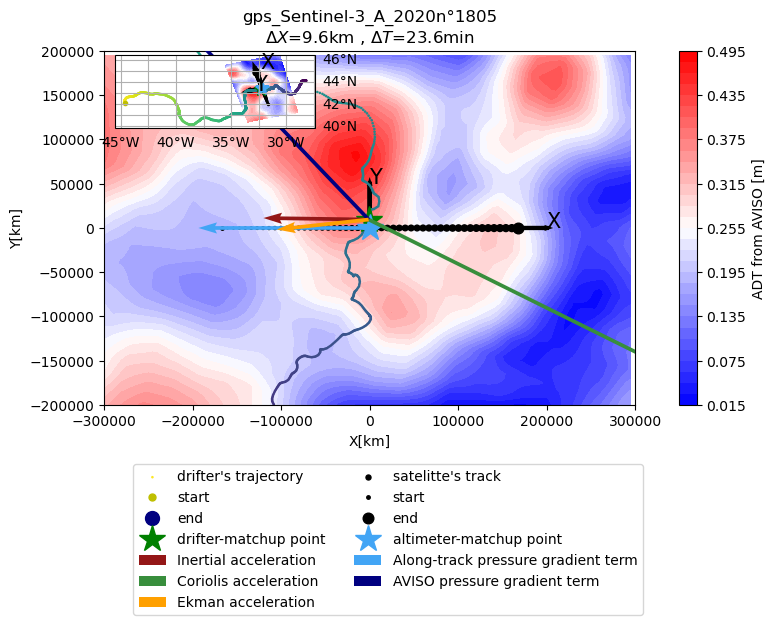

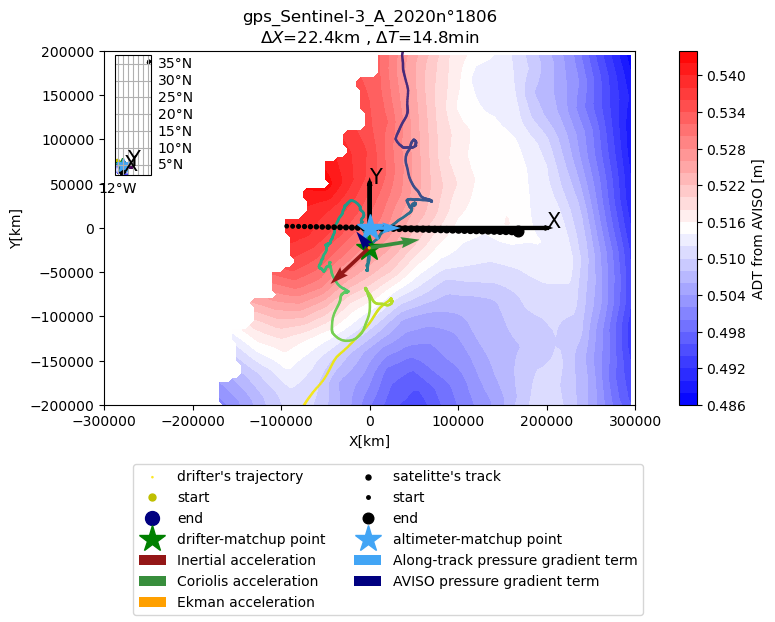

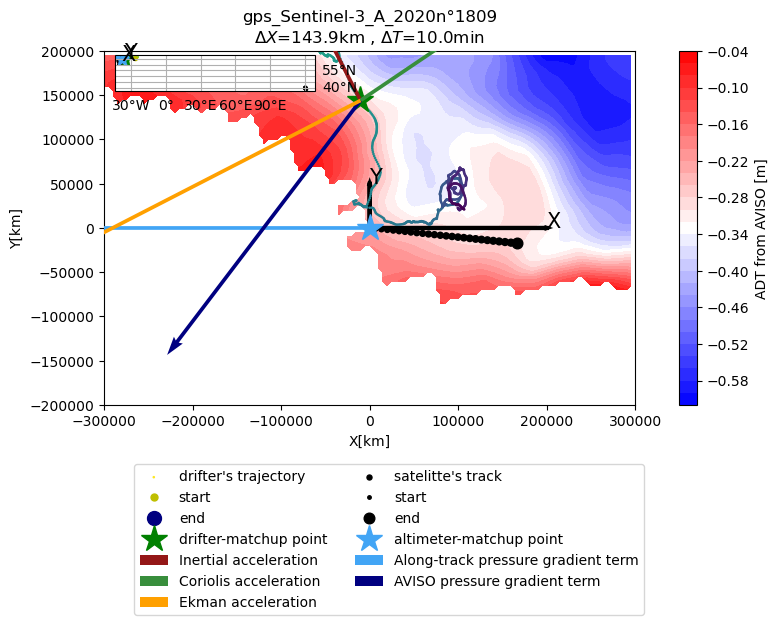

In [53]:
i = 1600
for nobs in dsm.obs.values[i:i+20] :
    plot_coloc_matchup_xy(l, nobs)